In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1TY_Ls73II1GMoE6mOnHxQ9sCSWWD9WlA"})
downloaded.GetContentFile('birds.zip')

In [0]:
!unzip birds.zip

In [0]:
from IPython import display

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

from skimage.io import imread
# from skimage.transform import resize
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time

torch.set_printoptions(linewidth=120)

%matplotlib inline

In [0]:
# VAR

batch_size = 128
data_dir = './data'
# img_x, img_y = 28, 28

d_steps = 1
g_steps = 100

d_lr = 0.0005
g_lr = 0.0005

n_epochs = 2
printing_steps = n_epochs//5

# make_some_noise = lambda size: torch.rand(batch_size, size)

dims = 256

In [0]:
class Pad(object):

    def __init__(self, size):
        assert isinstance(size, (int, tuple))
        self.output_size = size
    
    def __call__(self, img):
        # img = Image.open(sample)
        old_size = img.size
        ratio = self.output_size/max(old_size)
        new_size = int(old_size[0]*ratio), int(old_size[1]*ratio)
        img = img.resize(new_size, Image.ANTIALIAS)

        delta = self.output_size - new_size[0], self.output_size - new_size[1]
        padding = (delta[0]//2, delta[1]//2, delta[0]-delta[0]//2, delta[1]-delta[1]//2)
        img = ImageOps.expand(img, padding)
        return img

In [0]:
# DATA LOADING

dataset = ImageFolder(
    root=data_dir,
    transform=transforms.Compose([
        Pad(dims),
        transforms.ToTensor()
    ])
)

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [0]:
class DiscriminatorNet(nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self, n_features, n_out = 1):
        super(DiscriminatorNet, self).__init__()
        
        self.inp = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.inp(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 3*dims*dims)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, dims, dims)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self, n_features, n_out):
        super(GeneratorNet, self).__init__()
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [0]:
discriminator = DiscriminatorNet(3*dims*dims)
generator = GeneratorNet(100, 3*dims*dims)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1
# Number of epochs
num_epochs = 200

In [0]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [0]:
def print_images(images):
    fig = plt.figure(figsize=(16, 8))
    for i, img in enumerate(images, start=1):
        img = img.permute(1, 2, 0)
        img = (img.numpy()*255).astype(np.uint8)
        fig.add_subplot(2, 4, i)
        plt.imshow(img)
        if i==8:
            break
    plt.show()

In [22]:
for epoch in tqdm(range(1)):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Display Progress
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            print_images(test_images)
    print(f'At epoch #{epoch}:\n Discriminator Error = {d_error}\t\tGenerator Error = {g_error}\n')

RuntimeError: ignored

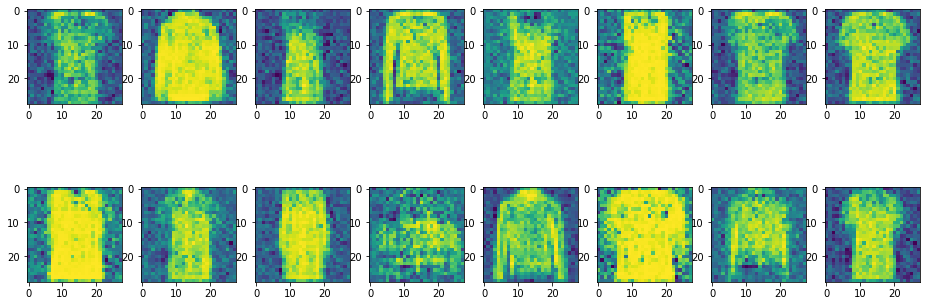

In [0]:
test_images = vectors_to_images(generator(noise(16))).data.cpu()
print_images(test_images)

In [0]:
torch.save(generator.state_dict(), 'generator_state_dict')
torch.save(discriminator.state_dict(), 'discriminator_state_dict')